# Neural Network using MLP Classifier

# Data Preparation

## Import Library and Data Set

In [108]:
import pandas as pd
import re
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import pickle

In [64]:
df = pd.read_csv('train_preprocess.tsv.txt', sep='\t', names=['text', 'label'], header=None)
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


## Cleansing Data

In [65]:
def clean(text):
    # lower case
    text = text.lower()
    # clean html entity (&{char};), emoticon (\\{char}), and @user tweet
    text = re.sub(r'&([^;]+);|\\x[a-z0-9]{2}|\\n|@([a-z0-9]+)\s', ' ', text)
    # add white space before after sentence
    text = " "+text+" "
    # clean special char except alphanumeric, whitespace
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # clean multiple whitespace
    text = re.sub(r'\s+', ' ', text)
    # clean whitespace at before/after sentence
    text = re.sub(r'^\s+|\s+$', '', text)
    return text

def word_substitute(text, kamus):
    # add white space before after sentence
    text = " "+text+" "
    # iterate kamus
    for word in kamus:
        # replace slay word
        text = text.replace(" "+word[0]+" ", " "+word[1]+" ")

    # clean whitespace at before/after sentence
    text = re.sub(r'^\s+|\s+$', '', text)
    return text

def kamus_alay():
    # read kamus alay and convert to array
    df_kamusalay = pd.read_csv('new_kamusalay.csv', header=None, encoding='latin1')
    kamus = [tuple(row) for index, row in df_kamusalay.iterrows()]
    return kamus

In [66]:
# drop duplicate
df.drop_duplicates()
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [67]:
# cleansing
data_cleansing = pd.DataFrame(df, columns=['text', 'label'])
kamus_alay = kamus_alay()
df['text'] = df['text'].apply(clean)
data_cleansing['text'] = df['text'].apply(lambda txt: word_substitute(txt, kamus_alay))
data_cleansing.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [68]:
# change label value to numeric
label_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
data_cleansing['label'] = df['label'].replace(label_mapping)
data_cleansing.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0
2,lokasi strategis di jalan sumatra bandung temp...,1
3,betapa bahagia nya diri ini saat unboxing pake...,1
4,aduh jadi mahasiswa jangan sombong dong kasih ...,2


## Feature Extraction using TFIDF

In [105]:
vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(data_cleansing['text'].tolist())

In [103]:
# Split train dataset

y = data_cleansing[['label']].values
X_tr, X_tt, y_tr, y_tt = train_test_split(tfidf_matrix, y, test_size = 0.2, random_state = 1)

# Modeling

## Finetuning

In [94]:
layers = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
scores = []
for layer in layers:
  mlp = MLPClassifier(
      hidden_layer_sizes=(layer),
      max_iter = 100,
      learning_rate_init= 0.1,
      random_state = 123,
      early_stopping=True,
      warm_start = True
  )
  mlp.fit(X_tr, y_tr)
  y_pred = mlp.predict(X_tt)
  score = accuracy_score(y_tt, y_pred)
  scores.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed w

<function matplotlib.pyplot.show(close=None, block=None)>

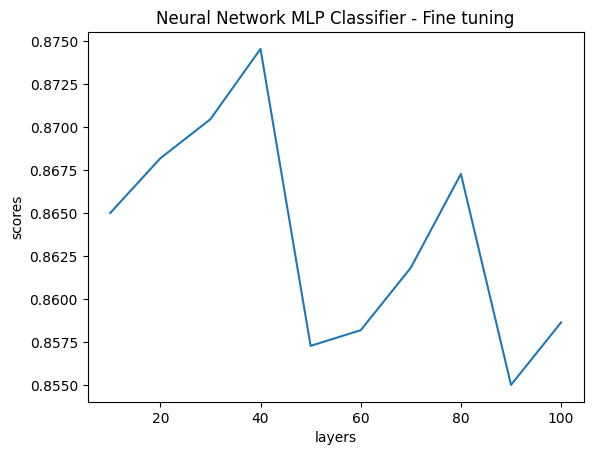

In [95]:
plt.Figure(figsize=(10, 5))
plt.title("Neural Network MLP Classifier - Fine tuning")
plt.plot(layers, scores)
plt.xlabel("layers")
plt.ylabel("scores")
plt.grid
plt.show


# Evaluation

In [104]:
mlp = MLPClassifier(
      hidden_layer_sizes=(40),
      max_iter = 100,
      learning_rate_init= 0.1,
      random_state = 123,
      early_stopping=True,
      warm_start = True,
      verbose=True
  )
mlp.fit(X_tr, y_tr)
y_pred = mlp.predict(X_tt)
score = accuracy_score(y_tt, y_pred)
score

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.47723356
Validation score: 0.863636
Iteration 2, loss = 0.13161128
Validation score: 0.869318
Iteration 3, loss = 0.05436933
Validation score: 0.864773
Iteration 4, loss = 0.03500394
Validation score: 0.865909
Iteration 5, loss = 0.03003543
Validation score: 0.861364
Iteration 6, loss = 0.02447739
Validation score: 0.862500
Iteration 7, loss = 0.01830254
Validation score: 0.862500
Iteration 8, loss = 0.01599580
Validation score: 0.860227
Iteration 9, loss = 0.01410529
Validation score: 0.867045
Iteration 10, loss = 0.01212353
Validation score: 0.860227
Iteration 11, loss = 0.01023890
Validation score: 0.864773
Iteration 12, loss = 0.00978162
Validation score: 0.865909
Iteration 13, loss = 0.00870795
Validation score: 0.867045
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


0.8745454545454545

In [110]:
print(classification_report(y_tt, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       239
           1       0.92      0.91      0.91      1289
           2       0.82      0.84      0.83       672

    accuracy                           0.87      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200



# Save Model

In [ ]:
pickle.dump(mlp, open("model_mlp.p","wb"))